In [1]:
import os
import sys
sys.path.append('../starter_files/')
sys.path.append('../../')
import seaborn as sns

In [2]:
# Built-in modules
import os
import glob
import json
from typing import Tuple, List
from datetime import datetime, timedelta
import pickle
import shutil
import warnings
warnings.filterwarnings('ignore')

# Basics of Python data handling and visualization
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm

import rasterio as rio
from rasterio import features
from tqdm import tqdm

In [3]:
from utils.data_transform import PlanetTransform, Sentinel1Transform, Sentinel2Transform
from utils.planet_reader import PlanetReader
from utils.sentinel_1_reader import S1Reader
from utils.sentinel_2_reader import S2Reader
from utils.data_loader import DataLoader

In [4]:
from ai4food.dataloaders import custom_sentinel_2_reader as CS2Reader

In [5]:
from importlib import reload

In [6]:
data_dir = '/work/ka1176/shared_data/2021-ai4food/raw_data/'

In [7]:
south_africa_tr_labels_dir_1 = os.path.join(data_dir, 'ref_fusion_competition_south_africa_train_labels/ref_fusion_competition_south_africa_train_labels_34S_19E_258N/labels.geojson')
south_africa_tr_labels_dir_2 = os.path.join(data_dir, 'ref_fusion_competition_south_africa_train_labels/ref_fusion_competition_south_africa_train_labels_34S_19E_259N/labels.geojson')
south_africa_te_labels_dir = os.path.join(data_dir, 'ref_fusion_competition_south_africa_test_labels/ref_fusion_competition_south_africa_test_labels_34S_20E_259N/labels.geojson')

In [8]:
south_africa_tr_labels_1 = gpd.read_file(south_africa_tr_labels_dir_1)
south_africa_tr_labels_2 = gpd.read_file(south_africa_tr_labels_dir_2)

# join both label dataframes
south_africa_tr_labels = south_africa_tr_labels_1.append(south_africa_tr_labels_2, ignore_index=True)

label_ids = south_africa_tr_labels['crop_id'].unique()
label_names = south_africa_tr_labels['crop_name'].unique()

south_africa_tr_labels.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4151 entries, 0 to 4150
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   fid         4151 non-null   int64   
 1   SHAPE_AREA  4151 non-null   float64 
 2   SHAPE_LEN   4151 non-null   float64 
 3   crop_id     4151 non-null   int64   
 4   crop_name   4151 non-null   object  
 5   geometry    4151 non-null   geometry
dtypes: float64(2), geometry(1), int64(2), object(1)
memory usage: 194.7+ KB


In [9]:
#SORT LABEL IDS and NAMES
zipped_lists = zip(label_ids, label_names)
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
label_ids, label_names = [ list(tuple) for tuple in  tuples]


In [10]:
label_names

['Wheat', 'Barley', 'Canola', 'Lucerne/Medics', 'Small grain grazing']

## Planet data (5-day)

In [11]:
train_dir = os.path.join(data_dir, 'ref_fusion_competition_south_africa_train_source_planet_5day')

## Planet data

In [12]:
train_dir = os.path.join(data_dir, 'ref_fusion_competition_south_africa_train_source_planet')

## Sentinel 1 data

In [13]:
train_dir = os.path.join(data_dir, 'ref_fusion_competition_south_africa_train_source_sentinel_1')

## Sentinel 2 data

In [11]:
train_dir = os.path.join(data_dir, 'ref_fusion_competition_south_africa_train_source_sentinel_2')

In [12]:
sentinel_train_1 = os.path.join(train_dir, 'ref_fusion_competition_south_africa_train_source_sentinel_2_34S_19E_258N_34S_19E_258N_2017')
sentinel_train_2 = os.path.join(train_dir, 'ref_fusion_competition_south_africa_train_source_sentinel_2_34S_19E_259N_34S_19E_259N_2017')

In [13]:
#Get data transformer for S2 images
sentinel_2_transformer=Sentinel2Transform()

In [70]:
#Initialize data reader for S2 images - region 1
reload(CS2Reader)
s2_reader = CS2Reader.S2Reader(input_dir=sentinel_train_2,
                             label_dir=south_africa_tr_labels_dir_2,
                             label_ids=label_ids,
                             transform=sentinel_2_transformer.transform,
                             min_area_to_ignore=1000, overwrite=True, include_cloud=False, n_processes=16)

INFO: Ignoring 5/2436 fields with area < 1000m2
starting the multiprocessing preparation
Copied data to shared arrays in 35 seconds
Starting 16 parallel processes
Finished setup in 0.38 minutes


In [18]:
X,y,m,fid = s2_reader[0] # the last band is the cloud index

In [19]:
X.shape, y, m.shape, fid

(torch.Size([76, 13, 32, 32]), 3, torch.Size([32, 32]), 79963)

In [20]:
#DEFINE TRUE COLOR IMAGING AND NDVI INDEXING FUNCTIONS FOR VISUALISATION OF S2 DATA: 

#Define NDVI index for S2 images
def ndvi(X):
    red = X[3]
    nir = X[7]
    return (nir-red) / (nir + red)

#Define True Color for S2 images
def true_color(X):
    blue = X[1]/(X[1].max()/255.0)
    green = X[2]/(X[2].max()/255.0)
    red = X[3]/(X[3].max()/255.0)
    tc = np.dstack((red,green,blue)) 
    
    return tc.astype('uint8')


In [21]:
print(f'Label of the selected sample: {label_names[y]} ({y})')

Label of the selected sample: Lucerne/Medics (3)


tensor(-0.4988)


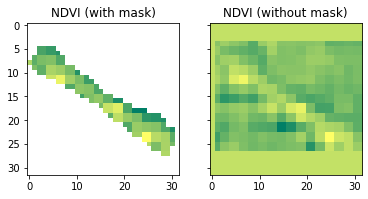

In [22]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
ax[0].imshow(ndvi(X[0]*m), cmap=plt.cm.summer)
ax[1].imshow(ndvi(X[0]), cmap=plt.cm.summer)
ax[0].set_title('NDVI (with mask)')
ax[1].set_title('NDVI (without mask)')

print(X[10, -1].mean())

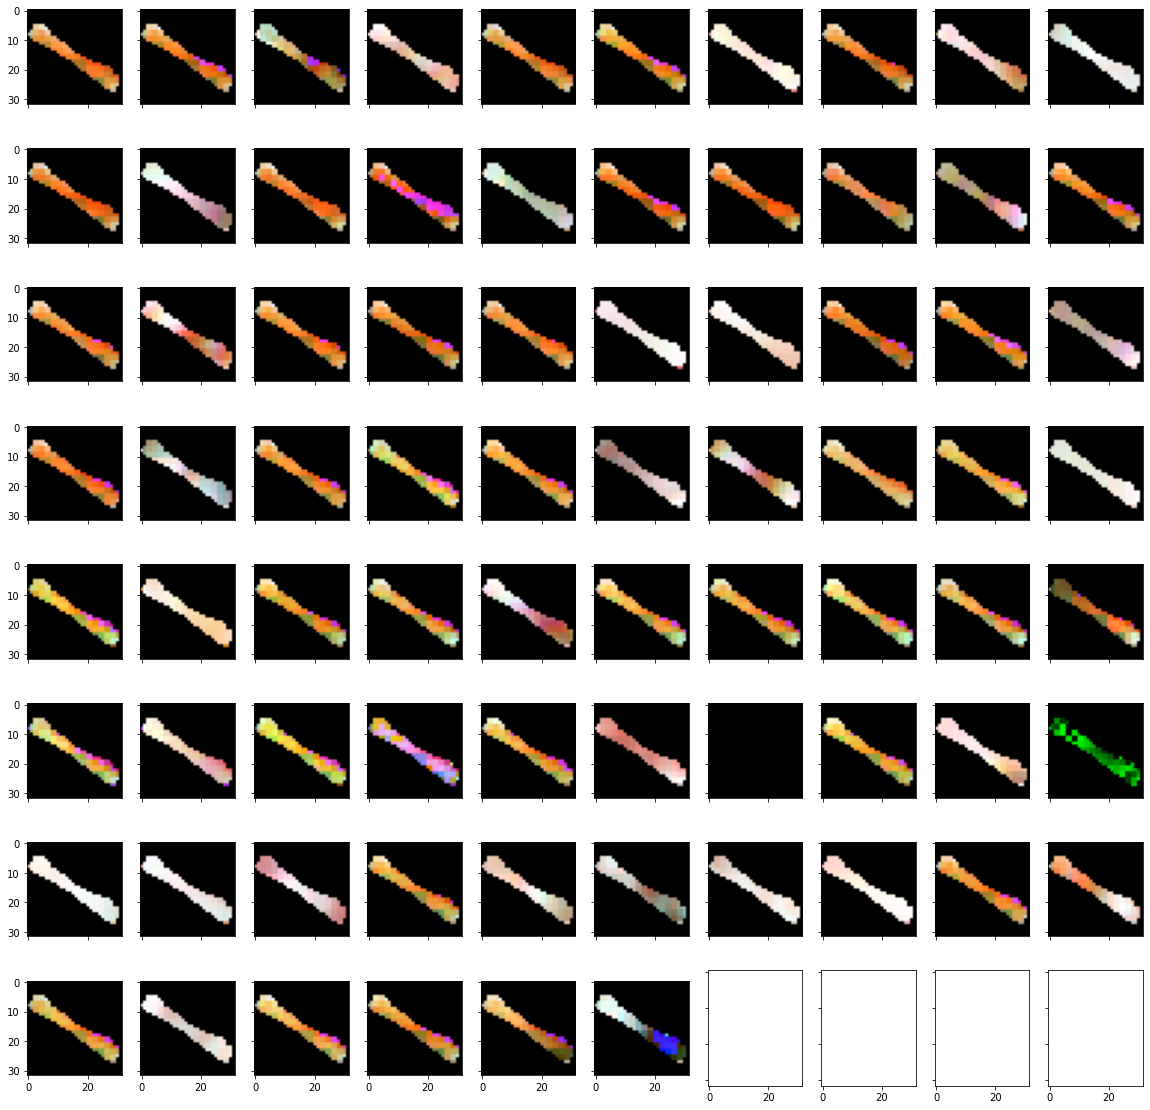

In [30]:
fig, ax = plt.subplots(8, 10, sharex=True, sharey=True, figsize=[20, 20])
ax = ax.flatten()
for i in range(76):
    ax[i].imshow(true_color(X[i]*m)) #, cmap=plt.cm.summer, vmin=-1, vmax=+1)

In [46]:
clouds = np.mean(X.numpy()[:,-1], axis=(-1,-2))
cloud_threshold = 0

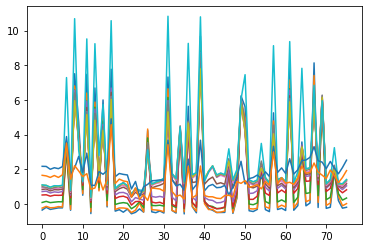

In [54]:
for i in range(12):
    plt.plot(range(76), np.mean(X[:, i].numpy() * m.numpy(), axis=(-1, -2)))

In [16]:
from scipy.interpolate import interp1d

empty 80014
empty 80105
empty 80106
empty 80150
empty 80257
empty 80331
empty 80332
empty 80379
empty 80388
empty 80481
empty 80491
empty 80532
empty 80535
empty 80568
empty 80588
empty 80694
empty 80695
empty 80699
empty 80781
empty 80788
empty 80897
empty 80899
empty 80930
empty 80959
empty 80984
does not exist 80985
empty 81058
empty 81059
empty 81171
empty 81226
empty 81247
empty 81558
empty 81659
empty 81665
empty 81676
empty 81679
empty 81712
empty 81883
empty 81919
empty 81939
empty 81953
empty 81959
empty 82060
empty 82850
empty 82942
empty 82964
empty 83103
empty 83105
empty 83115
empty 83159
empty 83235
empty 83248
empty 83400
does not exist 83416
does not exist 83451
empty 83473
does not exist 83485
empty 83519
empty 83521
empty 83522
empty 83523
empty 83524
empty 84001
empty 84039
does not exist 84068
empty 185290
empty 185291
empty 185331
empty 185370
empty 185373
empty 185403
empty 185404
empty 185405
empty 185437
empty 185475
empty 185657
empty 185658
empty 185970
empty 

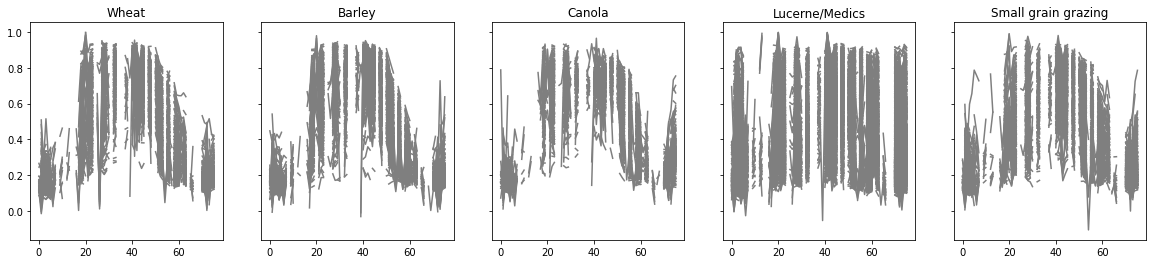

In [41]:
fig, ax = plt.subplots(1, 5, sharex=True, sharey=True, figsize=[20, 4])

time_range = np.arange(76)

ndvi_wheat = []
ndvi_barley = []
ndvi_canola = []
ndvi_lucerne = []
ndvi_grazing = []


for i in range(len(south_africa_tr_labels_2)): # len(south_africa_tr_labels_2)
    
    feature = south_africa_tr_labels_2.iloc[i]
    
    npyfile = os.path.join(sentinel_train_2, "fid_" + str(feature.fid) + ".npz")
    
    if not os.path.exists(npyfile):
        print('does not exist', feature.fid)
        continue
    
    object = np.load(npyfile)    
    image_stack = object["image_stack"]
    cloud_stack = object["cloud_stack"]
    
    mask = object["mask"].astype(bool)
    
    if np.sum(mask) == 0:
        print('empty', feature.fid)
        continue
        
    all_ndvi = []
        
    for j in range(76):
        clouds = cloud_stack[j, 0]
        clouds[mask==0] = None
        
        nir = image_stack[j, 7]
        red = image_stack[j, 3]
        
        nir[mask==0] = None
        red[mask==0] = None
        
        nir[clouds>10] = None
        red[clouds>10] = None
        
        ndvi = (nir - red) / (nir + red)
        all_ndvi.append(np.nanmean(ndvi))
        
    #is_finite = ~np.isnan(all_ndvi)
    #f = interp1d(time_range[is_finite], np.array(all_ndvi)[is_finite])
    
    #try:
    #    all_interp_ndvi = f(time_range)
    #except:
    #    continue
    
    all_interp_ndvi = all_ndvi # later interpolate
    
    if feature.crop_id-1 == 0:
        ndvi_wheat.append(all_interp_ndvi)
    elif feature.crop_id-1 == 1:
        ndvi_barley.append(all_interp_ndvi)
    elif feature.crop_id-1 == 2:
        ndvi_canola.append(all_interp_ndvi)
    elif feature.crop_id-1 == 3:
        ndvi_lucerne.append(all_interp_ndvi)
    elif feature.crop_id-1 == 4:
        ndvi_grazing.append(all_interp_ndvi)
        
    ax[feature.crop_id - 1].plot(all_ndvi, color='C7')
                
    ax[feature.crop_id - 1].set_title(feature.crop_name)

In [60]:
def interpolate(t, n):
    n = np.asarray(n)
    
    print(len(n))
    t = np.asarray(t)
    
    n = np.nanmean(n, axis=0)
    
    is_fin = ~np.isnan(n)
    f = interp1d(t[is_fin], n[is_fin])
    
    
    
    return t, f(t)

284
448
268
1074
275


Text(0.5, 0, 'Sentinel 2 time point')

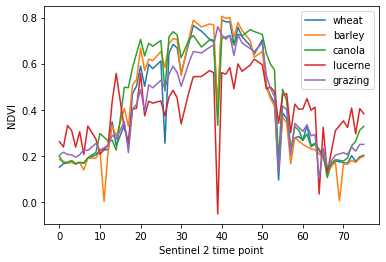

In [61]:


plt.plot(*interpolate(time_range, ndvi_wheat), label='wheat')
plt.plot(*interpolate(time_range, ndvi_barley), label='barley')
plt.plot(*interpolate(time_range, ndvi_canola), label='canola')
plt.plot(*interpolate(time_range, ndvi_lucerne), label='lucerne')
plt.plot(*interpolate(time_range, ndvi_grazing), label='grazing')

plt.legend()

plt.ylabel('NDVI')
plt.xlabel('Sentinel 2 time point')